In [1]:
###### %matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Pandas display all rows
pd.set_option('display.max_rows', None)
# Display all columns of a dataframe
pd.options.display.max_columns = None

from my_answers import NeuralNetwork
def MSE(y, Y):
    return np.mean((y-Y)**2)

####################
### Set the hyperparameters in you myanswers.py file ###
####################

iterations = 1500
learning_rate = 0.7
hidden_nodes = 100
output_nodes = 1


data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)


quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]







N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
    
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()


Progress: 0.2% ... Training loss: 1256. ... Validation loss: 1.367

C:\Users\Goose\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 0.7% ... Training loss: 19247 ... Validation loss: 15539

C:\Users\Goose\Documents\Udacity_Deep_Learning\DeepLearning_Code\02 - Neural Networks\Lesson 05 - Project\first-neural-network\my_answers.py:22: RuntimeWarning: overflow encountered in exp
  self.activation_function = lambda x: 1. / (1. + np.exp(-x))  # Replace 0 with your sigmoid calculation.


Progress: 11.2% ... Training loss: inf ... Validation loss: inf.136

C:\Users\Goose\Anaconda3\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\Goose\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in square


Progress: 11.5% ... Training loss: nan ... Validation loss: nan

C:\Users\Goose\Documents\Udacity_Deep_Learning\DeepLearning_Code\02 - Neural Networks\Lesson 05 - Project\first-neural-network\my_answers.py:97: RuntimeWarning: invalid value encountered in multiply
  hidden_error_term = hidden_error * (hidden_outputs * (1-hidden_outputs))


Progress: 99.9% ... Training loss: nan ... Validation loss: nan

C:\Users\Goose\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


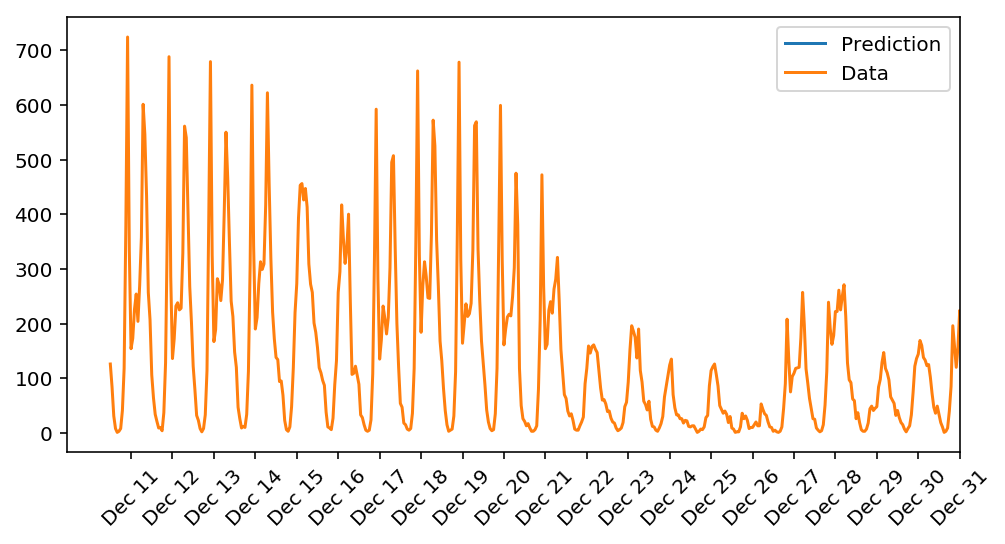

In [2]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)